In [1]:
## Imports and Initialization -------------------------------------------------|
print("Importing dependencies... ")

import sys
import os, os.path
sys.path.append(os.path.abspath(".."))  # Adjust path to package root

# third party
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# internal
import abstraction
import algorithm
from astropy.io import fits
from utility import IndexSchema, get_fits_paths, load_image_data
from examples.fits_to_mp4 import fits_to_mp4, data_to_mp4
from reference_method import ExternalRefs, RollingWindow

## Fetch Data ------------------------------------------------------------------

files_dir = os.path.abspath(os.path.join(".", "media", "large"))
files = get_fits_paths(files_dir)
files = files[610:622]
# print("\n".join(files))
print(f"{len(files)} files found")


Importing dependencies... 
12 files found



# Perform Destretching:

In [2]:
# create variable paths for destretching files

kernel_sizes: np.ndarray[np.int64] = np.array([128, 64])
out_off_dir = os.path.join(files_dir, "off")
out_off_control_dir = os.path.join(files_dir, "off_control")
out_avg_dir = os.path.join(files_dir, "avg")
out_ref_dir = os.path.join(files_dir, "ref")
out_dir = os.path.join(files_dir, "destretched")
out_dir_control = os.path.join(files_dir, "destretched_control")
out_off_final_dir = os.path.join(files_dir, "off_final")
print(out_off_dir)
print(out_avg_dir)
print(out_dir)

/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off
/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg
/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched


In [ ]:
# calculate offset vectors
print(f"calculating offsets... {out_off_dir}")
abstraction.calc_offset_vectors(
    files,
    out_off_dir,
    "off",
    kernel_sizes=kernel_sizes,
    # ref_method=ExternalRefs(files, get_fits_paths(out_ref_dir))
)

calculating offsets... /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off
Searching for image data in specified files...
ref image checksum: 3994515712.0
processing image #0../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06100.seq021.ext221.fits
ref image checksum: 0.5732421875
ref image checksum: 0.5732421875
processing image #1../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06110.seq021.ext231.fits
ref image checksum: 0.5732421875
ref image checksum: 3990718976.0
processing image #2../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06120.seq021.ext241.fits
ref image checksum: -5.6123046875
ref image checksum: 3995153664.0
processing image #3../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.2

['/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/offset00.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/offset01.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/offset02.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/offset03.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/offset04.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/offset05.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/offset06.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/offset07.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off/offset08.off.fits',
 '/home/tt

In [16]:
# calculate offset control vectors
print(f"calculating offsets... {out_off_control_dir}")
abstraction.calc_offset_vectors(
    files,
    out_off_control_dir,
    "off_cont",
    kernel_sizes=kernel_sizes,
    ref_method=RollingWindow(files, left=5, right=5)
)

calculating offsets... /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control
Searching for image data in specified files...
ref image checksum: 3997123584.0
processing image #0../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06100.seq021.ext221.fits
ref image checksum: 5.8076171875
ref image checksum: 3997123584.0
processing image #1../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06110.seq021.ext231.fits
ref image checksum: 5.8076171875
ref image checksum: 3997123584.0
processing image #2../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whitelight.cln.20170621_165941.im06120.seq021.ext241.fits
ref image checksum: 5.8076171875
ref image checksum: 3997123584.0
processing image #3../home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/whiteligh

['/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont00.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont01.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont02.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont03.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont04.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont05.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont06.off.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/off_control/off_cont07.off.fits',
 '/home/tteck/Documents/development/flct

In [9]:
# calculate rolling mean
print(f"calculating offset rolling mean...")
abstraction.calc_rolling_mean(
    #files, 
    get_fits_paths(out_off_dir),
    #out_ref_dir, 
    out_avg_dir,
    #"ref",
    "avg",
    window_left=5,
    window_right=5
)


calculating offset rolling mean...
averaging data #0..
averaging data #1..
averaging data #2..
averaging data #3..
averaging data #4..
averaging data #5..
averaging data #6..
averaging data #7..
averaging data #8..
averaging data #9..
averaging data #10..
writing /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg00.avg.fits..
averaging data #11..
writing /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg01.avg.fits..
writing /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg02.avg.fits..
writing /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg03.avg.fits..
writing /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg04.avg.fits..
writing /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg05.avg.fits..
writing /home/tteck/Documents/development/flc

['/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg00.avg.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg01.avg.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg02.avg.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg03.avg.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg04.avg.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg05.avg.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg06.avg.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg07.avg.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/avg/avg08.avg.fits',
 '/home/tteck/Documents/development/f

In [ ]:
# create final offset vectors
out_off_files = get_fits_paths(out_off_dir)
out_avg_files = get_fits_paths(out_avg_dir)

if not os.path.exists(out_off_final_dir):
    os.makedirs(out_off_final_dir)
    
out_name_digits: int = len(str(len(out_off_files)))

for i in range(len(out_off_files)):
    out_num = f"{i:0{out_name_digits}}"
    off = load_image_data(out_off_files[i], z_index=None)
    avg = load_image_data(out_avg_files[i], z_index=None)
    final = off - avg
    fits.writeto(
        os.path.join(out_off_final_dir, f"off_final{out_num}.fits"), 
        final, 
        overwrite=True
    )

In [3]:
# do actual destretch
result = abstraction.destretch_files(
    files,
    get_fits_paths(out_off_final_dir),
    out_dir,
    "destr",
    #in_avg_files=get_fits_paths(out_avg_dir),
)

# destretch control
abstraction.destretch_files(
    files,
    get_fits_paths(out_off_control_dir),
    out_dir_control,
    "destr_control"
)

Searching for image data in specified files...
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr00.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr01.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr02.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr03.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr04.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr05.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched/destr06.fits
destretched /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretche

['/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control00.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control01.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control02.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control03.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control04.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control05.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched_control/destr_control06.fits',
 '/home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/destretched

# Video Output

In [4]:
# output video files
out_file_orig_vid = os.path.join(files_dir, "video_original.mp4")
out_file_destr_vid = os.path.join(files_dir, "video_destretched.mp4")
out_file_destr_control_vid = os.path.join(files_dir, "video_destretched_control.mp4")
out_file_flow_vid = os.path.join(files_dir, "video_flowmap.mp4")
out_file_off_vid = os.path.join(files_dir, "video_offmap.mp4")
out_file_off_final_vid = os.path.join(files_dir, "video_offmap_final.mp4")
out_file_off_control_vid = os.path.join(files_dir, "video_offmap_control.mp4")

# output results as video files
fits_to_mp4(get_fits_paths(out_dir), out_file_destr_vid, 60, "copper", IndexSchema.XY, 0.2, 1.25)
fits_to_mp4(get_fits_paths(out_dir_control), out_file_destr_control_vid, 60, "copper", IndexSchema.XY, 0.2, 1.25)
fits_to_mp4(files, out_file_orig_vid, 60, "copper", IndexSchema.XY, 0.2, 1.25)
fits_to_mp4(get_fits_paths(out_off_dir), out_file_off_vid, 60, "copper", IndexSchema.TYX, 0.2, 1.25, True)
fits_to_mp4(get_fits_paths(out_off_final_dir), out_file_off_final_vid, 60, "copper", IndexSchema.TYX, 0.2, 1.25, True)
fits_to_mp4(get_fits_paths(out_off_control_dir), out_file_off_control_vid, 60, "copper", IndexSchema.TYX, 0.2, 1.25, True)
fits_to_mp4(get_fits_paths(out_avg_dir), out_file_flow_vid, 60, "copper", IndexSchema.TXY, 0.2, 1.25, True)

print("Demo Complete!")

Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_destretched.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_destretched_control.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_original.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_offmap.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_offmap_final.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_offmap_control.mp4, with 12 frames
Video saved to /home/tteck/Documents/development/flct_destretch/flctdestretch/examples/media/large/video_flowmap.mp4, with 12 frames
Demo Complete!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.615182844310667..2.6609495207351612].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4979273534748643..2.373323368060028].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2959826422354845].


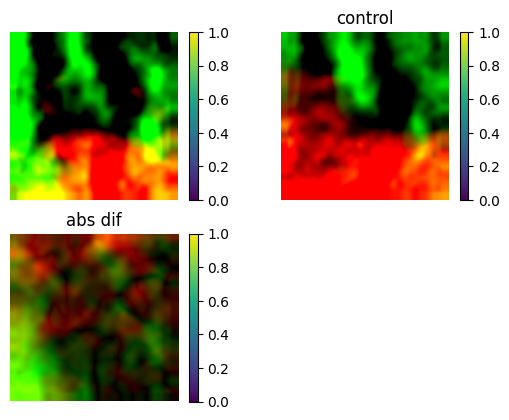

abs dif sum: 4.845263304167676


In [144]:
index = 1
axis = -1

out_off_final_files = get_fits_paths(out_off_final_dir)
out_off_control_files = get_fits_paths(out_off_control_dir)
off_final_data = load_image_data(out_off_final_files[index+1], z_index=None)
off_control_data = load_image_data(out_off_control_files[index], z_index=None)
off_final_data_rgb = np.zeros((off_final_data.shape[1], off_final_data.shape[2], 3))
off_control_data_rgb = np.zeros((off_control_data.shape[1], off_control_data.shape[2], 3))
off_final_data_rgb[:,:,0] = off_final_data[0]
off_final_data_rgb[:,:,1] = off_final_data[1]
off_control_data_rgb[:,:,0] = off_control_data[0]
off_control_data_rgb[:,:,1] = off_control_data[1]
end = axis+1
if axis < 0:
    axis = 0
    end = 3

plt.subplot(2,2,1)
plt.imshow(off_final_data_rgb[:,:,axis:end])
plt.colorbar()
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(off_control_data_rgb[:,:,axis:end])
plt.colorbar()
plt.title("control")
plt.axis("off")

dif = abs(off_final_data_rgb - off_control_data_rgb) / 2
plt.subplot(2,2,3)
plt.imshow(dif[:,:,axis:end])
plt.colorbar()
plt.title("abs dif")
plt.axis("off")

plt.show()

print(f"abs dif sum: {dif.sum()/100000.0}")